In [2]:
import numpy as np
import matplotlib.pyplot as plt

# If you want interactive inline behavior, uncomment ONE of these in Jupyter:
# %matplotlib notebook   # interactive toolbar, resizable
# %matplotlib inline     # static images (still fine for this explorer)

In [3]:
# Default viewport & rendering params
center_x = -0.5
center_y = 0.0
zoom = 1.0           # 1.0 = default; higher zooms in
width = 800          # image width in pixels
height = 600         # image height in pixels
max_iter = 300       # increase for more detail (slower)
escape_radius = 2.0  # standard radius


In [4]:
def mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iter=300, escape_radius=2.0):
    """
    Compute Mandelbrot escape iteration counts on a grid.
    Returns a 2D numpy array of iteration counts (height x width).
    """
    xs = np.linspace(xmin, xmax, width, dtype=np.float64)
    ys = np.linspace(ymin, ymax, height, dtype=np.float64)
    X, Y = np.meshgrid(xs, ys)
    C = X + 1j * Y

    Z = np.zeros_like(C, dtype=np.complex128)
    counts = np.zeros(C.shape, dtype=np.int32)

    mask = np.ones(C.shape, dtype=bool)

    for i in range(max_iter):
        Z[mask] = Z[mask]*Z[mask] + C[mask]
        escaped = np.abs(Z) > escape_radius
        newly_escaped = escaped & mask
        counts[newly_escaped] = i
        mask &= ~newly_escaped
        if not mask.any():
            break

    # Points that never escaped get max_iter
    counts[mask] = max_iter
    return counts


In [5]:
def viewport_from_center(center_x, center_y, zoom, aspect_ratio=4/3, span=3.5):
    """
    Compute (xmin, xmax, ymin, ymax) from center/zoom.
    span is the full width at zoom=1.0; effective width = span / zoom.
    """
    width_span = span / zoom
    height_span = width_span / aspect_ratio
    xmin = center_x - width_span/2
    xmax = center_x + width_span/2
    ymin = center_y - height_span/2
    ymax = center_y + height_span/2
    return xmin, xmax, ymin, ymax


def render_mandelbrot(center_x, center_y, zoom, width=800, height=600, max_iter=300, escape_radius=2.0, cmap="turbo"):
    """
    Render a static Mandelbrot image at given parameters.
    Returns (counts, (xmin, xmax, ymin, ymax)).
    """
    aspect = width / height
    xmin, xmax, ymin, ymax = viewport_from_center(center_x, center_y, zoom, aspect_ratio=aspect)
    counts = mandelbrot_set(xmin, xmax, ymin, ymax, width, height, max_iter=max_iter, escape_radius=escape_radius)

    plt.figure(figsize=(width/100, height/100), dpi=100)
    plt.imshow(counts, extent=(xmin, xmax, ymin, ymax), origin='lower', interpolation='nearest', cmap=cmap)
    plt.title(f"Mandelbrot (center=({center_x:.6f}, {center_y:.6f}), zoom={zoom:.3f}, iters={max_iter})")
    plt.xlabel("Re"); plt.ylabel("Im")
    plt.tight_layout()
    plt.show()
    return counts, (xmin, xmax, ymin, ymax)


In [6]:
class InteractiveExplorer:
    """
    Click-to-zoom explorer using Matplotlib events.

    - Left click to zoom in at cursor
    - Right click (or Ctrl/Cmd + click) to zoom out
    - 'r' to reset view
    - 's' to save current image (PNG)
    - Arrow keys ↑/↓ to adjust max iterations
    """
    def __init__(self, center_x=-0.5, center_y=0.0, zoom=1.0, width=800, height=600, max_iter=300, escape_radius=2.0, cmap="turbo"):
        self.init_params = (center_x, center_y, zoom)
        self.center_x = center_x
        self.center_y = center_y
        self.zoom = zoom
        self.width = width
        self.height = height
        self.max_iter = max_iter
        self.escape_radius = escape_radius
        self.cmap = cmap
        self.aspect = width / height

        self.fig, self.ax = plt.subplots(figsize=(width/100, height/100), dpi=100)
        self.redraw()

        self.cid_click = self.fig.canvas.mpl_connect('button_press_event', self.on_click)
        self.cid_key = self.fig.canvas.mpl_connect('key_press_event', self.on_key)

    def redraw(self):
        self.ax.clear()
        xmin, xmax, ymin, ymax = viewport_from_center(self.center_x, self.center_y, self.zoom, aspect_ratio=self.aspect)
        counts = mandelbrot_set(xmin, xmax, ymin, ymax, self.width, self.height, max_iter=self.max_iter, escape_radius=self.escape_radius)
        self.ax.imshow(counts, extent=(xmin, xmax, ymin, ymax), origin='lower', interpolation='nearest', cmap=self.cmap)
        self.ax.set_title(f"Mandelbrot (center=({self.center_x:.6f}, {self.center_y:.6f}), zoom={self.zoom:.3f}, iters={self.max_iter})")
        self.ax.set_xlabel("Re"); self.ax.set_ylabel("Im")
        self.fig.tight_layout()
        self.fig.canvas.draw_idle()

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        x = event.xdata
        y = event.ydata

        # Right click (button==3) => zoom out; left click => zoom in
        zoom_factor = 2.0
        if event.button == 3:
            self.zoom = max(1e-8, self.zoom / zoom_factor)
        else:
            self.zoom = self.zoom * zoom_factor

        self.center_x = x
        self.center_y = y
        self.redraw()

    def on_key(self, event):
        if event.key == 'r':
            self.center_x, self.center_y, self.zoom = self.init_params
            self.redraw()
        elif event.key == 's':
            fname = input("Enter filename (e.g., mandelbrot.png): ").strip() or "mandelbrot.png"
            self.fig.savefig(fname, dpi=200)
            print(f"Saved {fname}")
        elif event.key == 'up':
            self.max_iter = int(self.max_iter * 1.25) + 1
            print(f"iters -> {self.max_iter}")
            self.redraw()
        elif event.key == 'down':
            self.max_iter = max(10, int(self.max_iter / 1.25))
            print(f"iters -> {self.max_iter}")
            self.redraw()


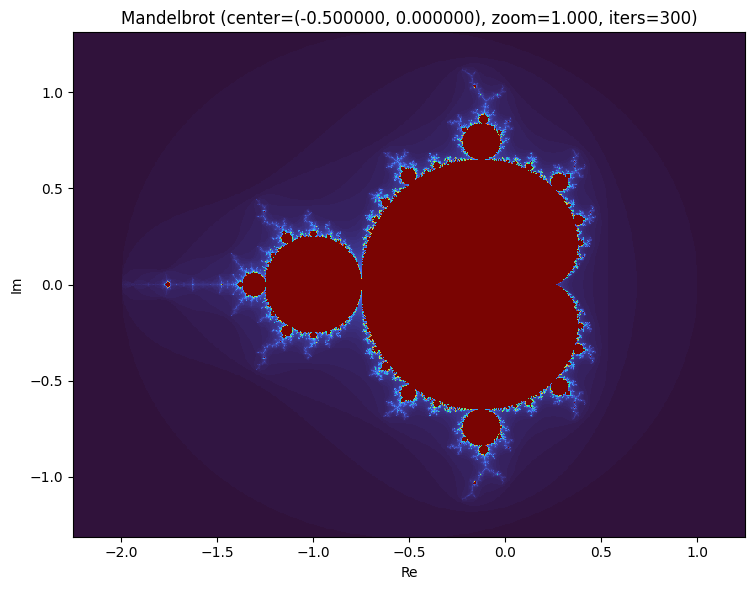

In [7]:
explorer = InteractiveExplorer(center_x=center_x, center_y=center_y, zoom=zoom,
                               width=width, height=height, max_iter=max_iter,
                               escape_radius=escape_radius, cmap="turbo")
plt.show()


In [8]:
# Example: render a high-resolution still (uncomment to run)
# counts, bounds = render_mandelbrot(center_x=-0.743643887037151, center_y=0.131825904205330,
#                                    zoom=2000, width=1920, height=1080, max_iter=2000, cmap="turbo")
# plt.savefig('mandelbrot_hires.png', dpi=300)
# print('Saved mandelbrot_hires.png')
